In [ ]:
# Standard library imports for environment variables, file operations, and data processing
from dotenv import load_dotenv
import os, json, textwrap, csv, pathlib
import pandas as pd  # For CSV data manipulation and analysis
from typing import List, Dict  # Type hints for better code documentation

In [ ]:
# LangChain + Neo4j imports for building Knowledge Graph RAG systems
from langchain_community.graphs import Neo4jGraph  # Interface to Neo4j graph database
from langchain_community.vectorstores import Neo4jVector  # Vector storage in Neo4j
from langchain_openai import OpenAIEmbeddings, ChatOpenAI  # OpenAI models for embeddings and chat
from langchain.text_splitter import RecursiveCharacterTextSplitter  # Split documents into chunks
from langchain.chains import RetrievalQAWithSourcesChain  # QA chain with source attribution
from langchain.prompts.prompt import PromptTemplate  # Custom prompt templates
from langchain.chains import GraphCypherQAChain  # Natural language to Cypher query translation

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load environment variables from .env file
# This includes API keys and database credentials
load_dotenv('.env', override=True)

True

In [ ]:
# Neo4j database connection configuration
NEO4J_URI       = os.getenv("NEO4J_URI")        # Neo4j database URI (e.g., bolt://localhost:7687)
NEO4J_USERNAME  = os.getenv("NEO4J_USERNAME")   # Database username
NEO4J_PASSWORD  = os.getenv("NEO4J_PASSWORD")   # Database password
NEO4J_DATABASE  = os.getenv("NEO4J_DATABASE") or "neo4j"  # Database name (default: neo4j)

# OpenAI configuration for embeddings and language models
OPENAI_API_KEY  = os.getenv("OPENAI_API_KEY")   # Your OpenAI API key
OPENAI_ENDPOINT = (os.getenv("OPENAI_BASE_URL") or "").rstrip("/") + "/embeddings"

# Vector index configuration for SEC document analysis
VECTOR_INDEX_NAME_SEC       = "form_10k_chunks"     # Index name for document chunks
VECTOR_NODE_LABEL_SEC       = "Chunk"               # Neo4j node label for text chunks
VECTOR_SOURCE_PROPERTY_SEC  = "text"                # Property containing the text content
VECTOR_EMBEDDING_PROPERTY_SEC = "textEmbedding"     # Property storing vector embeddings

# Vector index configuration for movie demo (Part 1)
VECTOR_INDEX_NAME_MOVIE     = "movie_tagline_embeddings"

# File paths to your data - modify these to point to your own files
USER_JSON_PATH = "data/0000950170-23-027948.json"   # SEC filing in JSON format
USER_CSV_PATH  = "data/form13.csv"                  # Investment holdings data

# Workshop configuration flags
USE_SYNTHETIC_MOVIE_DATA = True  # Create sample movie data for demonstration

In [ ]:
# Initialize connection to Neo4j Knowledge Graph
kg = Neo4jGraph(
    url=NEO4J_URI, 
    username=NEO4J_USERNAME, 
    password=NEO4J_PASSWORD, 
    database=NEO4J_DATABASE
)

# Refresh the schema to get current graph structure
kg.refresh_schema()
# Display the current graph schema (nodes, relationships, properties)
print(textwrap.fill(kg.schema, 80))

Node properties:  Relationship properties:  The relationships:


## Part 1 : Basics

In [ ]:
if USE_SYNTHETIC_MOVIE_DATA:
    # Clean up any existing demo data to start fresh
    kg.query("MATCH (n:Movie) DETACH DELETE n")   # Remove all Movie nodes and their relationships
    kg.query("MATCH (n:Person) DETACH DELETE n")  # Remove all Person nodes and their relationships

    # Create unique constraints to prevent duplicate nodes
    # This ensures data quality and enables efficient MERGE operations
    kg.query("""CREATE CONSTRAINT movie_title_unique IF NOT EXISTS FOR (m:Movie) REQUIRE m.title IS UNIQUE""")
    kg.query("""CREATE CONSTRAINT person_name_unique IF NOT EXISTS FOR (p:Person) REQUIRE p.name IS UNIQUE""")

    # Create sample movie data with taglines for vector similarity demonstration
    movies = [
        {"title": "Cloud Atlas", "released": 2012, "tagline": "Everything is connected."},
        {"title": "Forrest Gump", "released": 1994, "tagline": "Life is like a box of chocolates."},
        {"title": "The Matrix", "released": 1999, "tagline": "Welcome to the real world."},
    ]
    
    # Create sample people (actors)
    people = ["Tom Hanks", "Keanu Reeves", "Halle Berry"]
    
    # Define actor-movie relationships
    acted_in = [
        ("Tom Hanks", "Cloud Atlas"),
        ("Tom Hanks", "Forrest Gump"),
        ("Keanu Reeves", "The Matrix"),
        ("Halle Berry", "Cloud Atlas"),
    ]

    # Insert movies into the graph using MERGE (create if doesn't exist, otherwise use existing)
    for m in movies:
        kg.query("""
            MERGE (movie:Movie {title: $title})
            ON CREATE SET movie.released = $released, movie.tagline = $tagline
        """, params=m)

    # Insert people into the graph
    for name in people:
        kg.query("""MERGE (:Person {name: $name})""", params={"name": name})

    # Create ACTED_IN relationships between actors and movies
    for actor, film in acted_in:
        kg.query("""
            MATCH (p:Person {name: $actor}), (m:Movie {title: $movie})
            MERGE (p)-[:ACTED_IN]->(m)
        """, params={"actor": actor, "movie": film})

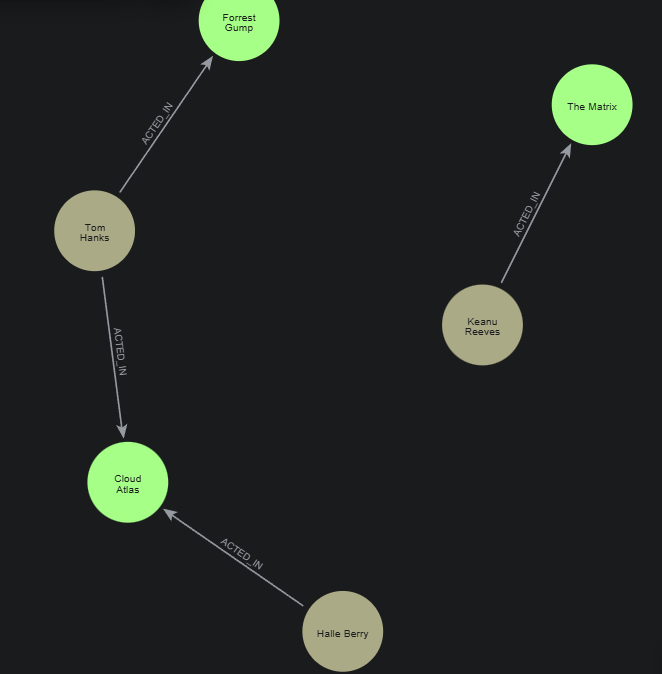

In [ ]:
# Basic graph statistics - count different types of nodes
print("Number of nodes:", kg.query("""MATCH (n) RETURN count(n) AS c""")[0]["c"])      # Total nodes
print("Number of movies:", kg.query("""MATCH (m:Movie) RETURN count(m) AS c""")[0]["c"])  # Movie nodes only
print("Number of people:", kg.query("""MATCH (p:Person) RETURN count(p) AS c""")[0]["c"])  # Person nodes only

Number of nodes: 6
Number of movies: 3
Number of people: 3


In [ ]:
# Query a specific movie node and return its properties
# This demonstrates basic node matching and property access
print(kg.query("""MATCH (cloudAtlas:Movie {title:"Cloud Atlas"}) RETURN cloudAtlas.released, cloudAtlas.tagline"""))

[{'cloudAtlas.released': 2012, 'cloudAtlas.tagline': 'Everything is connected.'}]


In [ ]:
# Find all movies that a specific actor appeared in
# This demonstrates relationship traversal: Person -[:ACTED_IN]-> Movie
print(kg.query("""MATCH (tom:Person {name:"Tom Hanks"})-[:ACTED_IN]->(m:Movie) RETURN tom.name, m.title"""))

[{'tom.name': 'Tom Hanks', 'm.title': 'Cloud Atlas'}, {'tom.name': 'Tom Hanks', 'm.title': 'Forrest Gump'}]


In [ ]:
# Find co-actors: other actors who appeared in the same movies as Tom Hanks
# Pattern: Tom Hanks -[:ACTED_IN]-> Movie <-[:ACTED_IN]- Co-actor
# This demonstrates bidirectional relationship traversal
print(kg.query("""
  MATCH (tom:Person {name:"Tom Hanks"})-[:ACTED_IN]->(m)<-[:ACTED_IN]-(co)
  RETURN co.name AS coActor, m.title AS movie
"""))

[{'coActor': 'Halle Berry', 'movie': 'Cloud Atlas'}]


## Part 2 : Vector index over text

In [ ]:
# Create a vector index on Movie nodes for semantic similarity search
# This enables us to find movies with similar taglines using vector embeddings
kg.query(f"""
  CREATE VECTOR INDEX {VECTOR_INDEX_NAME_MOVIE} IF NOT EXISTS
  FOR (m:Movie) ON (m.taglineEmbedding)
  OPTIONS {{ indexConfig: {{
    `vector.dimensions`: 1536,        -- OpenAI embeddings are 1536 dimensions
    `vector.similarity_function`: 'cosine'  -- Use cosine similarity for comparison
  }}}}
""")

[]

In [ ]:
# Generate vector embeddings for movie taglines using OpenAI's embedding model
# Only process movies that have taglines but don't yet have embeddings
kg.query("""
    MATCH (movie:Movie) WHERE movie.tagline IS NOT NULL AND movie.taglineEmbedding IS NULL
    WITH movie, genai.vector.encode(
        movie.tagline,        -- Text to embed
        "OpenAI",            -- Provider
        { token: $openAiApiKey, endpoint: $openAiEndpoint }  -- Authentication
    ) AS vector
    CALL db.create.setNodeVectorProperty(movie, "taglineEmbedding", vector)
""", params={"openAiApiKey": OPENAI_API_KEY, "openAiEndpoint": OPENAI_ENDPOINT})

[]

In [ ]:
# Verify that embeddings were created successfully
# Show movie details along with embedding information
kg.query("""
MATCH (m:Movie)
WHERE m.taglineEmbedding IS NOT NULL
RETURN
  m.title            AS title,
  m.tagline          AS tagline,
  size(m.taglineEmbedding) AS dims,        -- Should be 1536 for OpenAI embeddings
  m.taglineEmbedding[0..5] AS vector_preview  -- Show first 5 dimensions as sample
ORDER BY title
""")

[{'title': 'Cloud Atlas',
  'tagline': 'Everything is connected.',
  'dims': 1536,
  'vector_preview': [-0.006226008292287588,
   -0.017302287742495537,
   0.02564629167318344,
   -0.014397243969142437,
   -0.020284118130803108]},
 {'title': 'Forrest Gump',
  'tagline': 'Life is like a box of chocolates.',
  'dims': 1536,
  'vector_preview': [0.014015237800776958,
   -0.015920594334602356,
   0.007071556989103556,
   -0.009418086148798466,
   -0.010191737674176693]},
 {'title': 'The Matrix',
  'tagline': 'Welcome to the real world.',
  'dims': 1536,
  'vector_preview': [0.01938026398420334,
   -0.0086832819506526,
   -0.007637953385710716,
   -0.02706310898065567,
   -0.014596122317016125]}]

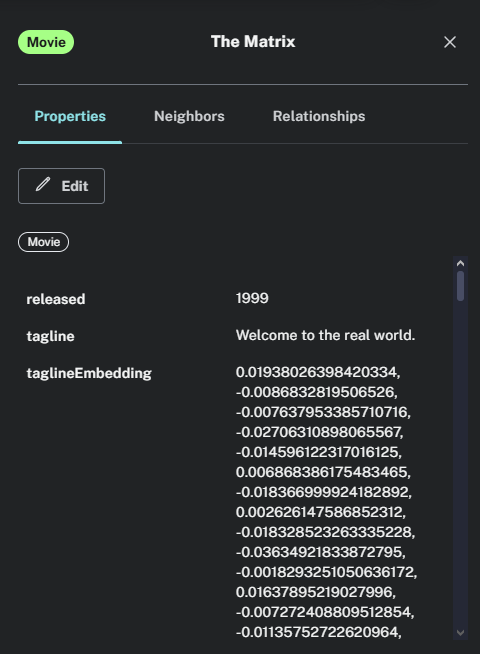

In [ ]:
# Perform semantic similarity search over movie taglines
# This demonstrates how vector embeddings enable finding conceptually similar content
question = "What movies are about reality or truth?"
results = kg.query("""
    WITH genai.vector.encode(
        $question, "OpenAI", { token: $openAiApiKey, endpoint: $openAiEndpoint }
    ) AS q
    CALL db.index.vector.queryNodes($index_name, 5, q) YIELD node AS movie, score
    RETURN movie.title AS title, movie.tagline AS tagline, score
""", params={"openAiApiKey": OPENAI_API_KEY, "openAiEndpoint": OPENAI_ENDPOINT,
             "question": question, "index_name": VECTOR_INDEX_NAME_MOVIE})
results

[{'title': 'The Matrix',
  'tagline': 'Welcome to the real world.',
  'score': 0.8787689208984375},
 {'title': 'Forrest Gump',
  'tagline': 'Life is like a box of chocolates.',
  'score': 0.8641510009765625},
 {'title': 'Cloud Atlas',
  'tagline': 'Everything is connected.',
  'score': 0.8610076904296875}]

In [ ]:
# Clean up demo data before moving to the next section
# This removes the movie graph to prepare for SEC document analysis
kg.query("MATCH (n:Movie) DETACH DELETE n")   # Delete all Movie nodes and relationships
kg.query("MATCH (n:Person) DETACH DELETE n")  # Delete all Person nodes and relationships

[]

## Part 3: Constructing a Knowledge Graph from Text Documents

In [ ]:
# Helper function to load and normalize JSON documents into standardized sections
# SEC 10-K forms typically have specific sections like Item 1, Item 1A, Item 7, Item 7A
def load_json_sections(path: str) -> Dict[str, str]:
    """
    Load a JSON file and extract/normalize it into standard 10-K sections.
    
    Args:
        path: Path to the JSON file
        
    Returns:
        Dictionary with keys: item1, item1a, item7, item7a
    """
    obj = json.load(open(path, "r", encoding="utf-8"))
    
    # Check if the JSON already has the expected 10-K structure
    keys = ["item1", "item1a", "item7", "item7a"]
    if all(k in obj for k in keys):
        return {k: obj[k] for k in keys}
    
    # If not in 10-K format, try to adapt generic text content
    # This handles cases where we have a simple text document
    text = obj.get("text") or obj.get("content") or ""
    return {
        "item1": text, 
        "item1a": text[: len(text)//3],  # Use first third as Item 1A sample
        "item7": text, 
        "item7a": text
    }

In [ ]:
# Load the SEC filing JSON file, with fallback if file doesn't exist
json_path = USER_JSON_PATH if pathlib.Path(USER_JSON_PATH).exists() else None
if not json_path:
    # Create a minimal fallback document for demo purposes
    fallback = {"text": "Demo text about a fictional company. It provides cloud storage and data services..."}
    json_path = "demo.json"
    json.dump(fallback, open(json_path, "w", encoding="utf-8"))

# Parse the JSON into standardized sections
sections = load_json_sections(json_path)

In [ ]:
# Initialize text splitter for breaking documents into manageable chunks
# Chunks should be small enough for LLM context windows but large enough to maintain meaning
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)

def chunk_sections(sections: Dict[str, str], form_id: str) -> List[Dict]:
    """
    Split document sections into overlapping chunks with metadata.
    
    Args:
        sections: Dictionary of section_name -> section_text
        form_id: Unique identifier for this form/document
        
    Returns:
        List of chunk dictionaries with text and metadata
    """
    out = []
    for item_name, item_text in sections.items():
        # Split the section text into overlapping chunks
        chunks = splitter.split_text(item_text or "")
        
        # Process each chunk and add metadata (limit to 20 chunks for demo speed)
        for i, chunk in enumerate(chunks[:20]):
            out.append({
                "text": chunk,                                    # The actual text content
                "f10kItem": item_name,                          # Which section this came from
                "chunkSeqId": i,                                # Position within the section
                "formId": form_id,                              # Parent document ID
                "chunkId": f"{form_id}-{item_name}-chunk{i:04d}",  # Unique chunk identifier
                # Placeholder metadata (in real use, extract from actual SEC filings, i was too lazy to implement this ...)
                "names": ["DemoCo, Inc."],
                "cik": "1002047",        # SEC Central Index Key
                "cusip6": "64110D",      # CUSIP identifier
                "source": f"file://{json_path}",
            })
    return out

# Generate chunks from the loaded sections
form_id = pathlib.Path(json_path).stem # type: ignore
chunks_with_meta = chunk_sections(sections, form_id=form_id)

In [ ]:
# Display the generated chunks to see the structure and metadata
chunks_with_meta

[{'text': '>Item 1.  \nBusiness\n\n\nOverview\n\n\nNetApp, Inc. (NetApp, we, us or the Company) is a global cloud-led, data-centric software company. We were incorporated in 1992 and are headquartered in San Jose, California. Building on more than three decades of innovation, we give customers the freedom to manage applications and data across hybrid multicloud environments. Our portfolio of cloud services, and storage infrastructure, powered by intelligent data management software, enables applications to run faster, more reliably, and more securely, all at a lower cost.\n\n\nOur opportunity is defined by the durable megatrends of data-driven digital and cloud transformations. NetApp helps organizations meet the complexities created by rapid data and cloud growth, multi-cloud management, and the adoption of next-generation technologies, such as AI, Kubernetes, and modern databases. Our modern approach to hybrid, multicloud infrastructure and data management, which we term ‘evolved clo

In [ ]:
# Show total number of chunks created from the document
len(chunks_with_meta)

23

In [ ]:
# Create unique constraint for chunks to prevent duplicates
kg.query("""CREATE CONSTRAINT unique_chunk IF NOT EXISTS FOR (c:Chunk) REQUIRE c.chunkId IS UNIQUE""")

# Define the MERGE query to upsert chunks (create if new, update if exists)
merge_chunk = """
MERGE (c:Chunk {chunkId: $p.chunkId})
  ON CREATE SET
    c.names=$p.names, c.formId=$p.formId, c.cik=$p.cik, c.cusip6=$p.cusip6,
    c.source=$p.source, c.f10kItem=$p.f10kItem, c.chunkSeqId=$p.chunkSeqId, c.text=$p.text
"""

# Insert all chunks into the Neo4j database
for rec in chunks_with_meta:
    kg.query(merge_chunk, params={"p": rec})

In [ ]:
# Verify that all chunks were successfully inserted into the database
print("Chunks in DB:", kg.query("MATCH (c:Chunk) RETURN count(c) AS c")[0]["c"])

Chunks in DB: 23


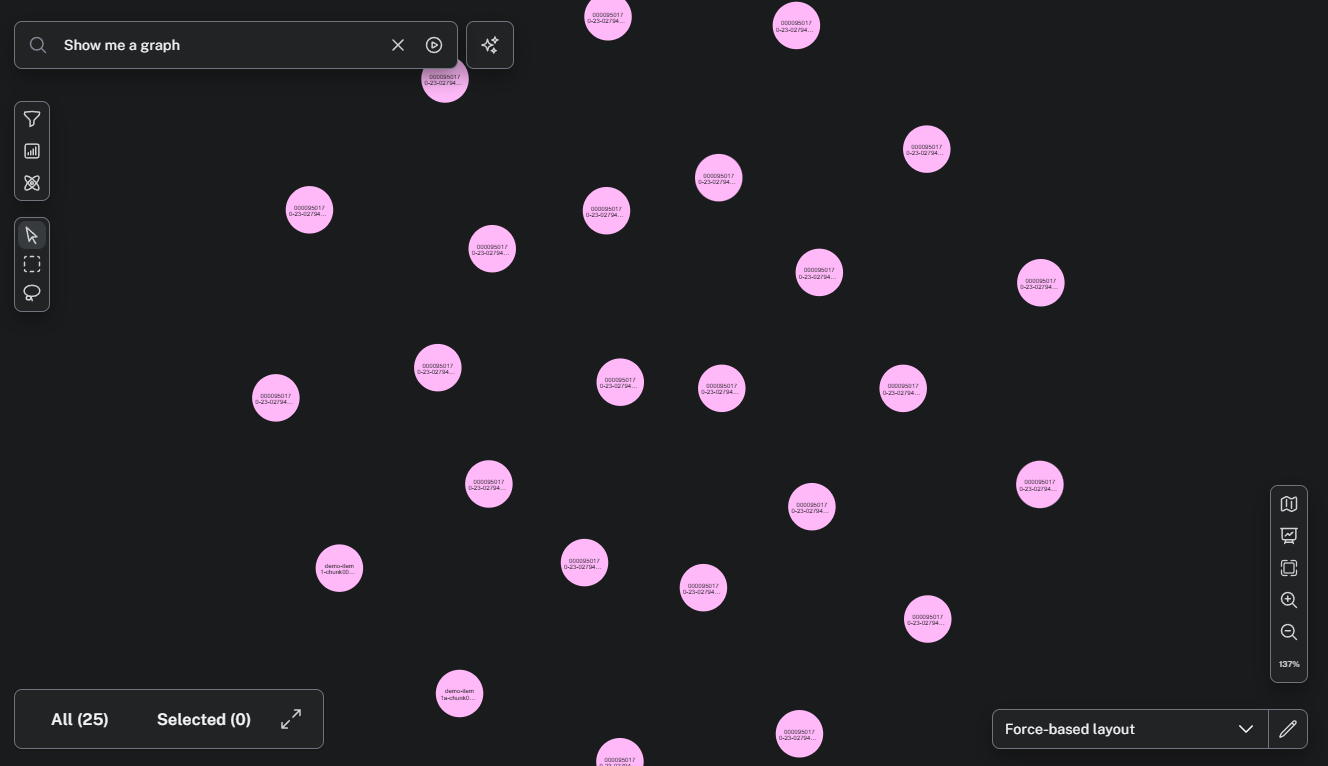

In [ ]:
# Create a vector index for semantic search over document chunks
# This enables similarity search over the text content of SEC filings
kg.query(f"""
  CREATE VECTOR INDEX `{VECTOR_INDEX_NAME_SEC}` IF NOT EXISTS
  FOR (c:Chunk) ON (c.{VECTOR_EMBEDDING_PROPERTY_SEC})
  OPTIONS {{ indexConfig: {{
    `vector.dimensions`: 1536,                    -- OpenAI embedding dimensions
    `vector.similarity_function`: 'cosine'       -- Cosine similarity for comparison
  }}}}
""")

[]

In [ ]:
# Generate embeddings for all chunks that don't have them yet
# This is where the text content gets converted to vector representations
kg.query(f"""
    MATCH (chunk:Chunk) WHERE chunk.{VECTOR_EMBEDDING_PROPERTY_SEC} IS NULL
    WITH chunk, genai.vector.encode(
      chunk.{VECTOR_SOURCE_PROPERTY_SEC}, "OpenAI", {{ token: $key, endpoint: $ep }}
    ) AS v
    CALL db.create.setNodeVectorProperty(chunk, "{VECTOR_EMBEDDING_PROPERTY_SEC}", v)
""", params={"key": OPENAI_API_KEY, "ep": OPENAI_ENDPOINT})

[]

In [ ]:
# Helper function for semantic similarity search over document chunks
def search_chunks(question: str, top_k: int = 5):
    """
    Search for chunks most similar to the given question.
    
    Args:
        question: Natural language query
        top_k: Number of most similar chunks to return
        
    Returns:
        List of dictionaries with score, text, and chunkId
    """
    q = f"""
      WITH genai.vector.encode($q, "OpenAI", {{ token: $key, endpoint: $ep }}) AS qe
      CALL db.index.vector.queryNodes($index, $k, qe) YIELD score, node
      RETURN score, node.text AS text, node.chunkId AS chunkId
    """
    return kg.query(q, params={"q": question, "key": OPENAI_API_KEY, "ep": OPENAI_ENDPOINT,
                               "index": VECTOR_INDEX_NAME_SEC, "k": top_k})

In [ ]:
# Test the semantic search functionality
# This finds chunks most relevant to understanding what the company does
search_chunks("In one sentence, what does the company do?")

[{'score': 0.8858642578125,
  'text': 'We generally enter into confidentiality agreements with our employees, resellers, distributors, customers, and suppliers. In addition, through various licensing arrangements, we receive certain rights to the intellectual property of others. We expect to maintain current licensing arrangements and to secure additional licensing arrangements in the future, as needed and to the extent available on reasonable terms and conditions, to support continued development and sales of our products and services. Some of these licensing arrangements require or may require royalty payments and other licensing fees. The amount of these payments and fees may depend on various factors, including but not limited to the structure of royalty payments; offsetting considerations, if any; and the degree of use of the licensed technology.\n\n\nThe industry in which we compete is characterized by rapidly changing technology, a large number of patents, and frequent claims an

## Part 4: Add structure: Form, SECTION, PART_OF, NEXT

In [ ]:
# Create NEXT relationships between consecutive chunks within each section
# This preserves the document structure and enables context-aware retrieval
for item in ["item1", "item1a", "item7", "item7a"]:
    kg.query("""
      MATCH (c:Chunk) WHERE c.formId=$formId AND c.f10kItem=$item
      WITH c ORDER BY c.chunkSeqId ASC
      WITH collect(c) AS section
      CALL apoc.nodes.link(section, "NEXT", {avoidDuplicates: true})
      RETURN size(section)
    """, params={"formId": form_info["formId"], "item": item})

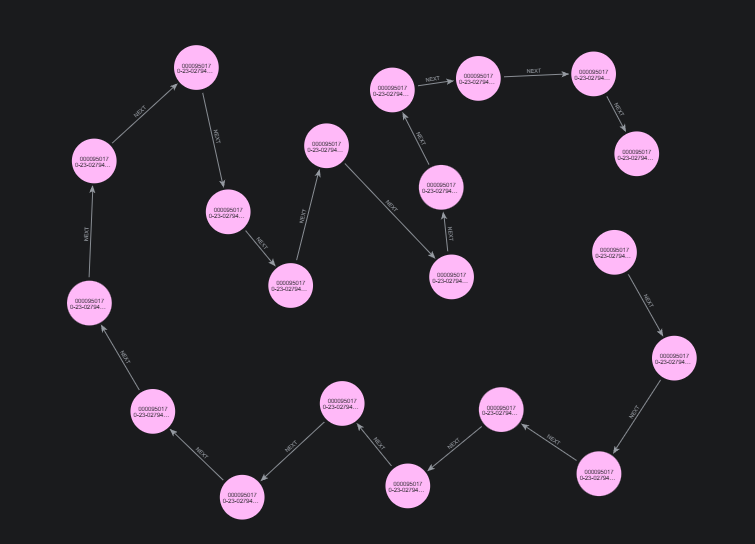

In [ ]:
# Extract form-level metadata from any chunk (they all share the same form info)
# This will be used to create a Form node that represents the entire document
form_info = kg.query("""
  MATCH (anyChunk:Chunk) WITH anyChunk LIMIT 1
  RETURN anyChunk { .names, .source, .formId, .cik, .cusip6 } AS info
""")[0]["info"]
form_info

{'cik': '00000000',
 'source': 'file://data/0000950170-23-027948.json',
 'formId': '0000950170-23-027948',
 'names': ['DemoCo, Inc.'],
 'cusip6': '000000'}

In [ ]:
# Create a Form node to represent the entire SEC filing document
# This provides a single node that aggregates all chunks from the same filing
kg.query("""
  MERGE (f:Form {formId: $formId})
  ON CREATE SET f.names=$names, f.source=$source, f.cik=$cik, f.cusip6=$cusip6
""", params=form_info)

[]

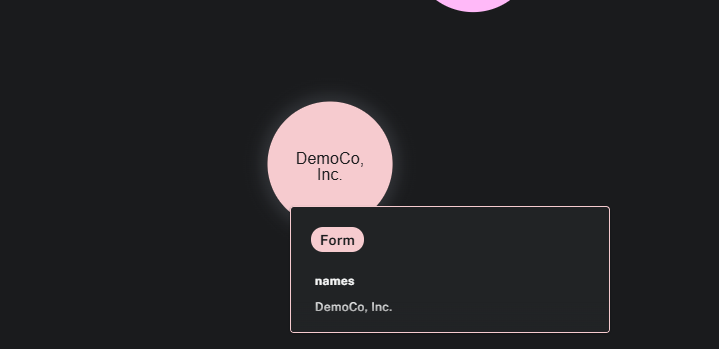

In [ ]:
# Connect chunks to their parent form with PART_OF relationships
kg.query("""
  MATCH (c:Chunk),(f:Form) WHERE c.formId=f.formId
  MERGE (c)-[:PART_OF]->(f)
""")

# Create SECTION relationships from Form to the first chunk of each section
# This provides easy navigation to section starts
kg.query("""
  MATCH (first:Chunk),(f:Form)
  WHERE first.formId=f.formId AND first.chunkSeqId=0
  MERGE (f)-[:SECTION {f10kItem:first.f10kItem}]->(first)
""")

[]

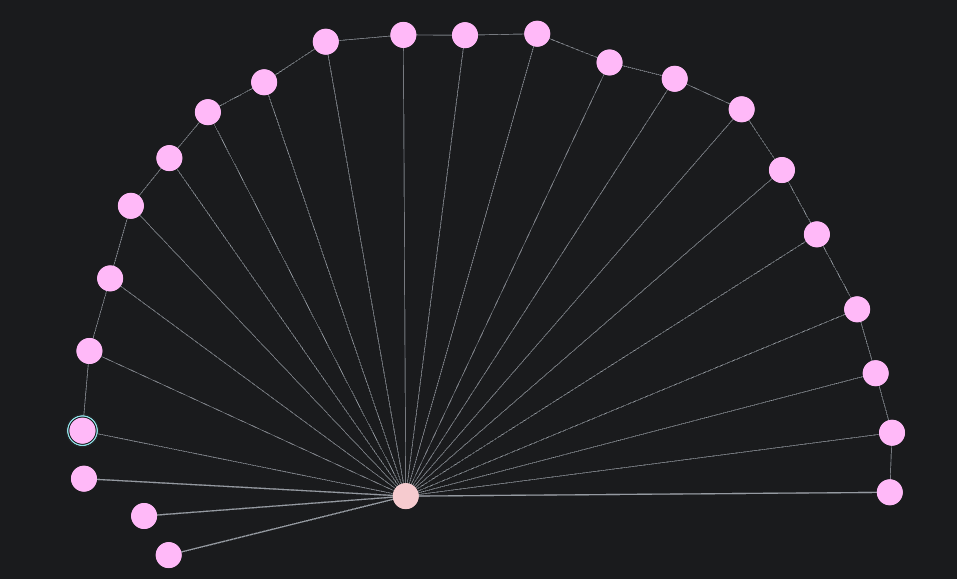

In [ ]:
# Define a "windowed" retrieval query that includes neighboring chunks for better context
# Instead of just returning the matched chunk, this returns the chunk plus its neighbors
# This provides more context while maintaining the semantic relevance of the original match
retrieval_query_window = f"""
MATCH window=(:{VECTOR_NODE_LABEL_SEC})-[:NEXT*0..1]->(node)-[:NEXT*0..1]->(:{VECTOR_NODE_LABEL_SEC})
WITH node, score, window AS w ORDER BY length(w) DESC LIMIT 1
WITH nodes(w) AS chunkList, node, score
UNWIND chunkList AS row
WITH collect(row.{VECTOR_SOURCE_PROPERTY_SEC}) AS textList, node, score
RETURN apoc.text.join(textList, " \\n ") AS text, score, node {{ .source }} AS metadata
"""

In [ ]:
# Create a LangChain vector store that uses our Neo4j vector index
# This integrates Neo4j's vector search with LangChain's retrieval framework
vector_store_window = Neo4jVector.from_existing_index(
    embedding=OpenAIEmbeddings(),
    url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE,
    index_name=VECTOR_INDEX_NAME_SEC,
    text_node_property=VECTOR_SOURCE_PROPERTY_SEC,
    retrieval_query=retrieval_query_window,  # Use our windowed query for better context
)

In [ ]:
# Initialize the language model for question answering
# Using GPT-4O-Mini for cost-effective but capable responses
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [ ]:
# Create a retrieval-based QA chain with source attribution
# This chain will retrieve relevant chunks and use them to answer questions
window_retriever = vector_store_window.as_retriever()
window_chain = RetrievalQAWithSourcesChain.from_chain_type(
    llm, chain_type="stuff", retriever=window_retriever
)

In [ ]:
# Test the QA chain with a business summary question
# This demonstrates how the system can synthesize information from retrieved chunks
resp = window_chain({"question": "In a single sentence, summarize the company's main business."}, return_only_outputs=True)
print(textwrap.fill(resp["answer"], 88))

The company's main business is providing software innovation, cloud integration, and
technology partnerships to deliver an outstanding experience to customers and partners
worldwide.


## Part 5: Expand the KG

In [ ]:
# Load investment holdings data from CSV file
# This contains information about which investment managers own shares in companies
if pathlib.Path(USER_CSV_PATH).exists():
    df = pd.read_csv(USER_CSV_PATH)

In [ ]:
# Preview the investment data structure
# This shows the columns and sample data we'll be working with
df.head()

,source,managerCik,managerAddress,managerName,reportCalendarOrQuarter,cusip6,cusip,companyName,value,shares
0,https://sec.gov/Archives/edgar/data/1000275/00...,1000275,"ROYAL BANK PLAZA, 200 BAY STREET, TORONTO, A6,...",Royal Bank of Canada,2023-06-30,64110D,64110D104,NETAPP INC,6.439500e+10,842850
1,https://sec.gov/Archives/edgar/data/1002784/00...,1002784,"1875 Lawrence Street, Suite 300, Denver, CO, 8...",SHELTON CAPITAL MANAGEMENT,2023-06-30,64110D,64110D104,NETAPP INC,2.989085e+09,39124
2,https://sec.gov/Archives/edgar/data/1007280/00...,1007280,"277 E TOWN ST, COLUMBUS, OH, 43215",PUBLIC EMPLOYEES RETIREMENT SYSTEM OF OHIO,2023-06-30,64110D,64110D104,Netapp Inc,8.170000e+06,106941
3,https://sec.gov/Archives/edgar/data/1007399/00...,1007399,"150 WEST MAIN STREET, SUITE 1700, NORFOLK, VA,...",WILBANKS SMITH & THOMAS ASSET MANAGEMENT LLC,2023-06-30,64110D,64110D104,NETAPP INC,5.055390e+08,6617
4,https://sec.gov/Archives/edgar/data/1008894/00...,1008894,"250 Park Avenue South, Suite 250, Winter Park,...",DEPRINCE RACE & ZOLLO INC,2023-06-30,64110D,64110D104,NETAPP INC,2.449239e+10,320581


In [ ]:
# Create constraints and indexes for the new node types
kg.query("""CREATE CONSTRAINT unique_manager IF NOT EXISTS FOR (n:Manager) REQUIRE n.managerCik IS UNIQUE""")
# Full-text index enables fast text search on manager names
kg.query("""CREATE FULLTEXT INDEX fullTextManagerNames IF NOT EXISTS FOR (mgr:Manager) ON EACH [mgr.managerName]""")

[]

In [ ]:
# Create Company nodes from the investment data
# Each unique company (identified by CUSIP6) gets its own node
for row in df.to_dict(orient="records"):
    kg.query("""
      MERGE (com:Company {cusip6: $cusip6})
      ON CREATE SET com.companyName=$companyName, com.cusip=$cusip
    """, params=row)

[]

In [ ]:
# Link Company nodes to Form nodes when they share the same CUSIP6
# This connects the SEC filing data with the investment data
kg.query("""
  MATCH (com:Company),(f:Form) WHERE com.cusip6=f.cusip6
  SET com.names = f.names    -- Sync company names from the form
  MERGE (com)-[:FILED]->(f)  -- Create FILED relationship
""")

[]

In [ ]:
# Create Manager nodes for investment firms
# Each manager is identified by their unique CIK (Central Index Key)
for row in df.to_dict(orient="records"):
    kg.query("""
      MERGE (mgr:Manager {managerCik: $managerCik})
      ON CREATE SET mgr.managerName=$managerName, mgr.managerAddress=$managerAddress
    """, params=row)

In [ ]:
# Create OWNS_STOCK_IN relationships between managers and companies
# The relationship includes investment details as properties
for row in df.to_dict(orient="records"):
    kg.query("""
      MATCH (mgr:Manager {managerCik: $managerCik}), (com:Company {cusip6: $cusip6})
      MERGE (mgr)-[owns:OWNS_STOCK_IN {reportCalendarOrQuarter: $reportCalendarOrQuarter}]->(com)
      ON CREATE SET owns.value = toFloat($value), owns.shares = toInteger($shares)
    """, params=row)

In [ ]:
# Refresh and display the updated graph schema
# Now we should see the new node types (Company, Manager, Form) and relationships
kg.refresh_schema()
print(textwrap.fill(kg.schema, 88))

Node properties: Chunk {chunkId: STRING, names: LIST, formId: STRING, cik: STRING,
cusip6: STRING, source: STRING, f10kItem: STRING, chunkSeqId: INTEGER, text: STRING,
textEmbedding: LIST} Form {names: LIST, formId: STRING, cik: STRING, cusip6: STRING,
source: STRING} Manager {managerCik: INTEGER, managerName: STRING, managerAddress:
STRING} Company {names: LIST, cusip6: STRING, companyName: STRING, cusip: STRING}
Relationship properties: SECTION {f10kItem: STRING} OWNS_STOCK_IN
{reportCalendarOrQuarter: STRING, value: FLOAT, shares: INTEGER} The relationships:
(:Chunk)-[:NEXT]->(:Chunk) (:Chunk)-[:PART_OF]->(:Form) (:Form)-[:SECTION]->(:Chunk)
(:Manager)-[:OWNS_STOCK_IN]->(:Company) (:Company)-[:FILED]->(:Form)


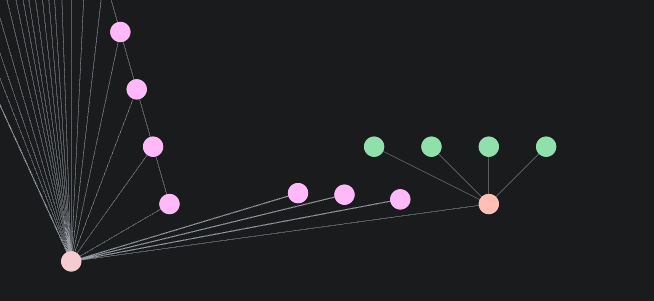

Now we can augment retrieval with investor facts (so the model “sees” them next to the chunk text)

In [ ]:
# Create an enhanced retrieval query that includes investor information
# This demonstrates how knowledge graphs can enrich RAG with structured data
investment_retrieval_query = f"""
MATCH (node:{VECTOR_NODE_LABEL_SEC})-[:PART_OF]->(f:Form),
      (f)<-[:FILED]-(com:Company),
      (com)<-[owns:OWNS_STOCK_IN]-(mgr:Manager)
WITH node, score, mgr, owns, com ORDER BY owns.shares DESC LIMIT 10
WITH collect(mgr.managerName + " owns " + owns.shares + " shares in " + com.companyName + 
             " at a value of $" + apoc.number.format(toInteger(owns.value)) + ".") AS lines,
     node, score
RETURN apoc.text.join(lines, "\\n") + "\\n" + node.{VECTOR_SOURCE_PROPERTY_SEC} AS text,
       score, {{ source: node.source }} AS metadata
"""

# Create a new vector store that includes investor context in retrievals
vector_store_with_investors = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(), url=NEO4J_URI, username=NEO4J_USERNAME, password=NEO4J_PASSWORD,
    database=NEO4J_DATABASE, index_name=VECTOR_INDEX_NAME_SEC,
    text_node_property=VECTOR_SOURCE_PROPERTY_SEC, retrieval_query=investment_retrieval_query
)

# Set up the QA chain with investor-enriched context
retriever_with_investors = vector_store_with_investors.as_retriever()
chain_with_investors = RetrievalQAWithSourcesChain.from_chain_type(
    llm, chain_type="stuff", retriever=retriever_with_investors
)

In [ ]:
# Test the investor-aware QA chain
# This should now include investment information in the response
print(chain_with_investors({"question": "Tell me about the company's investors."}, return_only_outputs=True))

{'answer': "The company's investors include:\n\n1. **Vanguard Group Inc.** - owns 27,643,006 shares in NetApp Inc. valued at approximately $2,111,925,659,000.\n2. **BlackRock Inc.** - owns 18,241,407 shares in NetApp Inc. valued at approximately $1,393,643,480,000.\n3. **PRIMECAP Management Co. (CA)** - owns 15,480,084 shares in NetApp Inc. valued at approximately $1,182,678,418,000.\n\n", 'sources': 'file://data/0000950170-23-027948.json'}


## Part 6 

In [ ]:
# Refresh schema for Cypher generation and create a prompt template
kg.refresh_schema()
SCHEMA_TXT = kg.schema

# Define a prompt template for converting natural language to Cypher queries
# This instructs the LLM on how to generate valid Cypher given the graph schema
CYPHER_GENERATION_TEMPLATE = """Task:Generate Cypher statement to query a graph database.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:
{schema}
Note: Do not include explanations or apologies. Output ONLY Cypher.

The question is:
{question}"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema","question"],
    template=CYPHER_GENERATION_TEMPLATE
)

In [ ]:
# Use a more capable model for Cypher generation
# Converting natural language to precise query syntax requires strong reasoning
llm_strong = ChatOpenAI(model="gpt-5", temperature=0)

In [ ]:
# Create a GraphCypherQAChain for natural language to Cypher translation
# This chain converts questions to Cypher queries, executes them, and formats answers
# You can even use different LLMs for different tasks:
# cypher_llm=ChatOpenAI(model="gpt-5", temperature=0),   # strong for NL→Cypher
# qa_llm=ChatOpenAI(model="gpt-5-mini", temperature=0),  # cheaper for answer phrasing
cypher_chain = GraphCypherQAChain.from_llm(
    llm_strong,
    graph=kg,
    verbose=False,
    cypher_prompt=CYPHER_GENERATION_PROMPT,
    allow_dangerous_requests=True,  # Required for write operations
)

def ask_cypher(q: str):
    """Helper function to ask questions and format responses nicely."""
    print(f"Q: {q}")
    print(textwrap.fill(cypher_chain.run(q), 100), "\n")

In [ ]:
# Test the Cypher generation with a geographic question
# This should generate a query to find managers in San Francisco
ask_cypher("What investment firms are in San Francisco?")

Q: What investment firms are in San Francisco?
ALGERT GLOBAL LLC, CHARLES SCHWAB INVESTMENT MANAGEMENT INC, Cutler Group LLC / CA, Fund Management
at Engine No. 1 LLC, Legato Capital Management LLC, Parallax Volatility Advisers, L.P., SKBA CAPITAL
MANAGEMENT LLC, WELLS FARGO & COMPANY/MN, WETHERBY ASSET MANAGEMENT INC, Woodline Partners LP are in
San Francisco. 



In [ ]:
# Test with a question about document structure
# This should traverse from chunks to forms to find filing companies
ask_cypher("What companies filed the form connected to our chunks?")

Q: What companies filed the form connected to our chunks?
NETAPP INC. 



In [ ]:
# Compare plain retrieval vs investor-augmented retrieval on the same question
# This demonstrates how knowledge graph augmentation enriches the context
plain_answer = window_chain({"question": "Describe the company in one sentence."}, return_only_outputs=True)
aug_answer   = chain_with_investors({"question": "Describe the company in one sentence."}, return_only_outputs=True)
print("PLAIN:", textwrap.fill(plain_answer["answer"], 88))
print("\nAUGMENTED:", textwrap.fill(aug_answer["answer"], 88))

PLAIN: The company focuses on research and development to deliver innovative cloud solutions
and competes in the cloud operations marketplace with a strong emphasis on proprietary
rights.

AUGMENTED: NetApp, Inc. is a global cloud-led, data-centric software company that provides
customers with the ability to manage applications and data across hybrid multicloud
environments, leveraging intelligent data management software to enhance performance,
reliability, and security at a lower cost.


In [ ]:
# Compare responses on an investor-specific question
# The augmented chain should provide much richer information about investors
plain_answer = window_chain({"question": "Describe the company's investors in one sentence."}, return_only_outputs=True)
aug_answer   = chain_with_investors({"question": "Describe the company's investors in one sentence."}, return_only_outputs=True)
print("PLAIN:", textwrap.fill(plain_answer["answer"], 88))
print("\nAUGMENTED:", textwrap.fill(aug_answer["answer"], 88))

PLAIN: The company's investors are not mentioned in the provided content.

AUGMENTED: The company's investors include Vanguard Group Inc., which owns 27,643,006 shares valued
at approximately $2.11 trillion, BlackRock Inc., which owns 18,241,407 shares valued at
about $1.39 trillion, and PRIMECAP Management Co., which owns 15,480,084 shares valued
at around $1.18 trillion.
